# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [ ]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

## Populating namespaces

In [ ]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [ ]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [4]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
'wget' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


# MobileNet Transfer Learning for Malaria Diagnosis

This section implements transfer learning using MobileNet architecture for malaria diagnosis. MobileNet is a lightweight deep neural network designed for mobile and embedded vision applications, utilizing depthwise separable convolutions to reduce computational cost while maintaining accuracy.

## Model Architecture Overview

MobileNet employs depthwise separable convolutions, which factorize standard convolutions into:
- **Depthwise convolution**: Applies a single filter per input channel
- **Pointwise convolution**: 1×1 convolution to combine outputs

This approach significantly reduces parameters and computational requirements compared to traditional CNNs while maintaining competitive performance for image classification tasks.

## Environment Setup and Data Preprocessing

In [1]:
# MobileNet-specific imports and dependencies
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import cv2
import glob
from collections import Counter

# Set plotting style for academic quality
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration parameters
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"Number of GPUs: {len(tf.config.experimental.list_physical_devices('GPU'))}")

TensorFlow version: 2.20.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: False
Number of GPUs: 0


=== Dataset Distribution Analysis ===
Parasitized cells: 13,779
Uninfected cells: 13,779
Total images: 27,558
Class balance ratio: 1.000


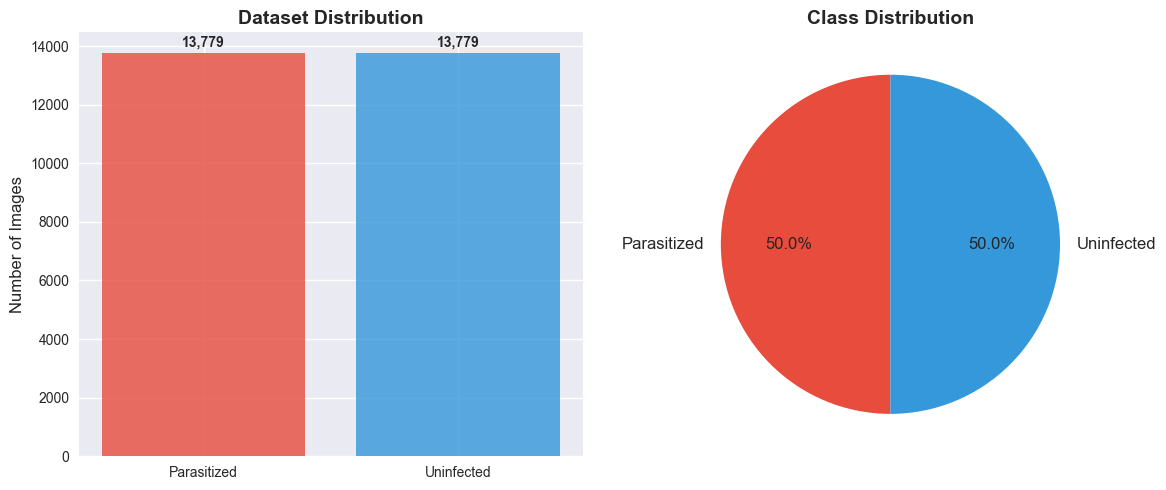

In [6]:
# Data paths configuration
import os
import glob

BASE_DIR = '.'
CELL_IMAGES_DIR = os.path.join(BASE_DIR, 'cell_images')
PARASITIZED_DIR = os.path.join(CELL_IMAGES_DIR, 'Parasitized')
UNINFECTED_DIR = os.path.join(CELL_IMAGES_DIR, 'Uninfected')

# Model hyperparameters
IMG_HEIGHT, IMG_WIDTH = 224, 224  # MobileNet standard input size
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
FINE_TUNE_LEARNING_RATE = 0.0001

# Data distribution analysis
def analyze_dataset_distribution():
    """Analyze and visualize the distribution of parasitized vs uninfected cells."""
    
    # Check if directories exist
    if not os.path.exists(CELL_IMAGES_DIR):
        print(f"Dataset directory not found: {CELL_IMAGES_DIR}")
        print("Available directories:")
        for item in os.listdir('.'):
            if os.path.isdir(item):
                print(f"  - {item}")
        return 0, 0
    
    # Count images in each category
    parasitized_count = len(glob.glob(os.path.join(PARASITIZED_DIR, '*.png')))
    uninfected_count = len(glob.glob(os.path.join(UNINFECTED_DIR, '*.png')))
    
    total_images = parasitized_count + uninfected_count
    
    if total_images == 0:
        print("No images found. Please ensure the dataset is downloaded and extracted.")
        return 0, 0
    
    print("=== Dataset Distribution Analysis ===")
    print(f"Parasitized cells: {parasitized_count:,}")
    print(f"Uninfected cells: {uninfected_count:,}")
    print(f"Total images: {total_images:,}")
    print(f"Class balance ratio: {parasitized_count/uninfected_count:.3f}")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot
    categories = ['Parasitized', 'Uninfected']
    counts = [parasitized_count, uninfected_count]
    colors = ['#e74c3c', '#3498db']
    
    bars = ax1.bar(categories, counts, color=colors, alpha=0.8)
    ax1.set_title('Dataset Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Images', fontsize=12)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 12})
    ax2.set_title('Class Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return parasitized_count, uninfected_count

# Execute analysis
parasitized_count, uninfected_count = analyze_dataset_distribution()

In [7]:
# Data preprocessing and augmentation pipeline
def create_data_generators(validation_split=0.2):
    """
    Create data generators for training and validation with appropriate augmentation.
    
    Returns:
        train_generator: Training data generator with augmentation
        val_generator: Validation data generator without augmentation
    """
    
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split
    )
    
    # Validation data generator (only rescaling)
    val_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        validation_split=validation_split
    )
    
    # Create training generator
    train_generator = train_datagen.flow_from_directory(
        CELL_IMAGES_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=RANDOM_SEED
    )
    
    # Create validation generator
    val_generator = val_datagen.flow_from_directory(
        CELL_IMAGES_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False,
        seed=RANDOM_SEED
    )
    
    print("=== Data Generator Information ===")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Number of classes: {train_generator.num_classes}")
    print(f"Class indices: {train_generator.class_indices}")
    print(f"Steps per epoch (training): {len(train_generator)}")
    print(f"Validation steps: {len(val_generator)}")
    
    return train_generator, val_generator

# Create data generators
train_gen, val_gen = create_data_generators()

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
=== Data Generator Information ===
Training samples: 22048
Validation samples: 5510
Number of classes: 2
Class indices: {'Parasitized': 0, 'Uninfected': 1}
Steps per epoch (training): 689
Validation steps: 173


In [5]:
# Download and extract dataset (Windows compatible)
import urllib.request
import zipfile
import shutil

def download_and_extract_dataset():
    """Download and extract the malaria dataset from NIH."""
    
    dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    zip_filename = "cell_images.zip"
    extract_dir = "cell_images"
    
    # Check if dataset already exists
    if os.path.exists(extract_dir) and os.path.exists(os.path.join(extract_dir, 'Parasitized')) and os.path.exists(os.path.join(extract_dir, 'Uninfected')):
        print("Dataset already exists. Skipping download.")
        return True
    
    try:
        # Remove existing files if they exist
        if os.path.exists(zip_filename):
            os.remove(zip_filename)
        if os.path.exists(extract_dir):
            shutil.rmtree(extract_dir)
        
        print(f"Downloading dataset from {dataset_url}...")
        print("This may take several minutes (dataset is ~350MB)...")
        
        # Download with progress
        def show_progress(block_num, block_size, total_size):
            downloaded = block_num * block_size
            percent = min(100, (downloaded / total_size) * 100)
            print(f"\rProgress: {percent:.1f}% ({downloaded // (1024*1024):.1f}/{total_size // (1024*1024):.1f} MB)", end='')
        
        urllib.request.urlretrieve(dataset_url, zip_filename, reporthook=show_progress)
        print("\nDownload completed!")
        
        # Extract the dataset
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall('.')
        
        # Clean up zip file
        os.remove(zip_filename)
        print("Dataset extracted successfully!")
        
        # Verify extraction
        parasitized_dir = os.path.join(extract_dir, 'Parasitized')
        uninfected_dir = os.path.join(extract_dir, 'Uninfected')
        
        if os.path.exists(parasitized_dir) and os.path.exists(uninfected_dir):
            parasitized_count = len([f for f in os.listdir(parasitized_dir) if f.endswith('.png')])
            uninfected_count = len([f for f in os.listdir(uninfected_dir) if f.endswith('.png')])
            print(f"Verification: Found {parasitized_count} parasitized and {uninfected_count} uninfected images")
            return True
        else:
            print("Error: Expected directories not found after extraction")
            return False
            
    except Exception as e:
        print(f"Error downloading/extracting dataset: {e}")
        return False

# Download the dataset
success = download_and_extract_dataset()

This may take several minutes (dataset is ~350MB)...
Progress: 100.0% (337.0/337.0 MB)
Download completed!
Extracting dataset...
Dataset extracted successfully!
Verification: Found 13779 parasitized and 13779 uninfected images


## MobileNet Architecture Implementation

MobileNet utilizes depthwise separable convolutions to achieve efficiency while maintaining performance. The architecture consists of:
- **Initial standard convolution layer**
- **13 depthwise separable convolution layers**
- **Global average pooling**
- **Fully connected classification layer**

We implement two experimental conditions:
1. **Feature Extraction** (`trainable=False`): Use pre-trained features as fixed feature extractor
2. **Fine-tuning** (`trainable=True`): Allow all layers to be updated during training

In [8]:
# MobileNet model creation functions
def create_mobilenet_model(trainable=False, dropout_rate=0.5):
    """
    Create a MobileNet model for binary classification.
    
    Args:
        trainable (bool): Whether to make the base model trainable
        dropout_rate (float): Dropout rate for regularization
    
    Returns:
        tf.keras.Model: Compiled MobileNet model
    """
    
    # Load pre-trained MobileNet without top classification layer
    base_model = MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Set trainability of base model
    base_model.trainable = trainable
    
    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Preprocess inputs for MobileNet (scales to [-1, 1])
    x = tf.keras.applications.mobilenet.preprocess_input(inputs)
    
    # Pass through base model
    x = base_model(x, training=trainable)
    
    # Global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    
    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
    
    # Final classification layer (sigmoid for binary classification)
    outputs = Dense(1, activation='sigmoid', name='predictions')(x)
    
    # Create and compile model
    model = Model(inputs, outputs)
    
    return model

def compile_model(model, learning_rate=LEARNING_RATE):
    """
    Compile the model with appropriate optimizer and metrics.
    
    Args:
        model: Keras model to compile
        learning_rate (float): Learning rate for optimizer
    """
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    
    return model

# Create callback functions for training
def create_callbacks(model_name, patience=10):
    """
    Create training callbacks for model optimization.
    
    Args:
        model_name (str): Name for saving model checkpoints
        patience (int): Patience for early stopping
    
    Returns:
        list: List of callbacks
    """
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-8,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f'best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    return callbacks

print("MobileNet model creation functions defined successfully!")

MobileNet model creation functions defined successfully!


## Evaluation Framework

Comprehensive evaluation metrics and visualization functions for model performance assessment. This includes:
- **Performance Metrics**: Accuracy, Precision, Recall, F1-Score, AUC
- **Learning Curves**: Training and validation loss/accuracy progression
- **Confusion Matrix**: Classification performance visualization
- **ROC Curve**: Receiver Operating Characteristic analysis

In [9]:
# Evaluation and visualization functions
def calculate_f1_score(precision, recall):
    """Calculate F1-score from precision and recall."""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def evaluate_model(model, test_generator, model_name):
    """
    Comprehensive model evaluation with metrics calculation.
    
    Args:
        model: Trained Keras model
        test_generator: Data generator for evaluation
        model_name (str): Name of the model for reporting
    
    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    
    # Reset generator
    test_generator.reset()
    
    # Get predictions
    print(f"Evaluating {model_name}...")
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    # Get true labels
    true_labels = test_generator.classes
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes)
    recall = recall_score(true_labels, predicted_classes)
    f1 = f1_score(true_labels, predicted_classes)
    auc_score = roc_auc_score(true_labels, predictions)
    
    # Store results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score,
        'predictions': predictions,
        'predicted_classes': predicted_classes,
        'true_labels': true_labels
    }
    
    # Print results
    print(f"\n=== {model_name} Evaluation Results ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC:       {auc_score:.4f}")
    
    return results

def plot_learning_curves(history, model_name):
    """
    Plot training and validation learning curves.
    
    Args:
        history: Keras training history object
        model_name (str): Name of the model for plot title
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} - Learning Curves', fontsize=16, fontweight='bold')
    
    # Plot training and validation loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', color='#e74c3c', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='#3498db', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training and validation accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', color='#e74c3c', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#3498db', linewidth=2)
    axes[0, 1].set_title('Model Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision', color='#e74c3c', linewidth=2)
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', color='#3498db', linewidth=2)
        axes[1, 0].set_title('Model Precision', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall', color='#e74c3c', linewidth=2)
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', color='#3498db', linewidth=2)
        axes[1, 1].set_title('Model Recall', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, predicted_classes, model_name):
    """
    Plot confusion matrix with detailed statistics.
    
    Args:
        true_labels: True class labels
        predicted_classes: Predicted class labels
        model_name (str): Name of the model for plot title
    """
    
    cm = confusion_matrix(true_labels, predicted_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontweight='bold')
    plt.ylabel('True Label', fontweight='bold')
    
    # Add statistics
    tn, fp, fn, tp = cm.ravel()
    plt.figtext(0.02, 0.02, f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curve(true_labels, predictions, model_name):
    """
    Plot ROC curve with AUC score.
    
    Args:
        true_labels: True class labels
        predictions: Model prediction probabilities
        model_name (str): Name of the model for plot title
    """
    
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='#e74c3c', linewidth=3, label=f'{model_name} (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='#34495e', linestyle='--', linewidth=2, label='Random Classifier')
    plt.fill_between(fpr, tpr, alpha=0.2, color='#e74c3c')
    
    plt.title(f'{model_name} - ROC Curve', fontsize=14, fontweight='bold')
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Evaluation framework functions defined successfully!")

Evaluation framework functions defined successfully!


# Experiment Execution

## Experiment 1: Feature Extraction (trainable=False)

In this experiment, we use the pre-trained MobileNet as a fixed feature extractor. The convolutional base is frozen, and only the newly added classifier layers are trained. This approach:
- **Preserves** learned ImageNet features
- **Reduces** computational requirements
- **Minimizes** overfitting risk
- **Suitable** when target domain is similar to ImageNet

In [11]:
# Experiment 1: MobileNet Feature Extraction (trainable=False)
print("="*60)
print("EXPERIMENT 1: MobileNet Feature Extraction")
print("Configuration: trainable=False")
print("="*60)

# Create and compile model for feature extraction
model_fe = create_mobilenet_model(trainable=False)
model_fe = compile_model(model_fe, learning_rate=LEARNING_RATE)

# Display model architecture
print("\nModel Architecture Summary:")
print(f"Total parameters: {model_fe.count_params():,}")

# Calculate trainable parameters correctly for TensorFlow
trainable_params = sum([tf.size(var).numpy() for var in model_fe.trainable_variables])
print(f"Trainable parameters: {trainable_params:,}")

# Display model layers
print("\nKey Architecture Details:")
print(f"Input shape: {model_fe.input_shape}")
print(f"Base model trainable: {model_fe.layers[2].trainable}")
print(f"Number of layers: {len(model_fe.layers)}")

# Create callbacks
callbacks_fe = create_callbacks('mobilenet_feature_extraction', patience=15)

# Train the model
print("\nStarting training...")
start_time = tf.timestamp()

history_fe = model_fe.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks_fe,
    verbose=1
)

end_time = tf.timestamp()
training_time_fe = float(end_time - start_time)

print(f"\nTraining completed in {training_time_fe:.2f} seconds")
print(f"Best validation accuracy: {max(history_fe.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history_fe.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_fe.history['val_accuracy'][-1]:.4f}")

EXPERIMENT 1: MobileNet Feature Extraction
Configuration: trainable=False

Model Architecture Summary:
Total parameters: 3,229,889
Trainable parameters: 1,025

Key Architecture Details:
Input shape: (None, 224, 224, 3)
Base model trainable: True
Number of layers: 5

Starting training...


C:\Users\evotech\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5045 - loss: 0.7067 - precision: 0.5105 - recall: 0.5179
Epoch 1: val_accuracy improved from None to 0.50109, saving model to best_mobilenet_feature_extraction.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 1178s 2s/step - accuracy: 0.5016 - loss: 0.7001 - precision: 0.5017 - recall: 0.4739 - val_accuracy: 0.5011 - val_loss: 0.6923 - val_precision: 0.6500 - val_recall: 0.0047 - learning_rate: 0.0010
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.5099 - loss: 0.6941 - precision: 0.5110 - recall: 0.5464
Epoch 2: val_accuracy did not improve from 0.50109
689/689 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - accuracy: 0.5095 - loss: 0.6946 - precision: 0.5094 - recall: 0.5154 - val_accuracy: 0.5000 - val_loss: 0.6944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.5082 - loss: 0.6951 - precision: 0.5080 - recall: 0.5114
Epoch 3: val_accuracy improved from 0.50109 to 0.51234, saving model to best_mobilenet_feature_extraction.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.5049 - loss: 0.6948 - precision: 0.5049 - recall: 0.5021 - val_accuracy: 0.5123 - val_loss: 0.6912 - val_precision: 0.5063 - val_recall: 0.9891 - learning_rate: 0.0010
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.5122 - loss: 0.6937 - precision: 0.5021 - recall: 0.3947
Epoch 4: val_accuracy did not improve from 0.51234
689/689 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.5096 - loss: 0.6938 - precision: 0.5098 - recall: 0.4966 - val_accuracy: 0.5067 - val_loss: 0.6909 - val_precision: 0.5034 - val_recall: 0.9942 - learning_rate: 0.0010
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.5128 - loss: 0.6929 - precision: 0.5147 - recall: 0.5384
Epoch 5: val_accuracy improved from 0.51234 to 0.59038, saving model to best_mobilenet_feature_extraction.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.5136 - loss: 0.6931 - precision: 0.5134 - recall: 0.5201 - val_accuracy: 0.5904 - val_loss: 0.6902 - val_precision: 0.5562 - val_recall: 0.8940 - learning_rate: 0.0010
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5097 - loss: 0.6937 - precision: 0.5116 - recall: 0.5465
Epoch 6: val_accuracy did not improve from 0.59038
689/689 ━━━━━━━━━━━━━━━━━━━━ 830s 1s/step - accuracy: 0.5170 - loss: 0.6928 - precision: 0.5167 - recall: 0.5249 - val_accuracy: 0.5078 - val_loss: 0.6899 - val_precision: 0.7312 - val_recall: 0.0247 - learning_rate: 0.0010
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.5199 - loss: 0.6928 - precision: 0.5161 - recall: 0.4821
Epoch 7: val_accuracy improved from 0.59038 to 0.61833, saving model to best_mobilenet_feature_extraction.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 646s 938ms/step - accuracy: 0.5144 - loss: 0.6935 - precision: 0.5143 - recall: 0.5171 - val_accuracy: 0.6183 - val_loss: 0.6895 - val_precision: 0.6380 - val_recall: 0.5470 - learning_rate: 0.0010
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.5111 - loss: 0.6952 - precision: 0.5102 - recall: 0.4743
Epoch 8: val_accuracy did not improve from 0.61833
689/689 ━━━━━━━━━━━━━━━━━━━━ 642s 931ms/step - accuracy: 0.5186 - loss: 0.6930 - precision: 0.5188 - recall: 0.5135 - val_accuracy: 0.5036 - val_loss: 0.6900 - val_precision: 0.5018 - val_recall: 0.9964 - learning_rate: 0.0010
Epoch 9/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.5212 - loss: 0.6919 - precision: 0.5202 - recall: 0.5288
Epoch 9: val_accuracy did not improve from 0.61833
689/689 ━━━━━━━━━━━━━━━━━━━━ 635s 921ms/step - accuracy: 0.5220 - loss: 0.6921 - precision: 0.5220 - recall: 0.5224 - val_accuracy: 0.5093 - val_loss: 0.6890 - val_precision: 0.7429 - val_recall

689/689 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.5183 - loss: 0.6927 - precision: 0.5184 - recall: 0.5174 - val_accuracy: 0.6292 - val_loss: 0.6873 - val_precision: 0.6132 - val_recall: 0.7002 - learning_rate: 0.0010
Epoch 17/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.5315 - loss: 0.6901 - precision: 0.5315 - recall: 0.5214
Epoch 17: val_accuracy did not improve from 0.62922
689/689 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.5283 - loss: 0.6907 - precision: 0.5286 - recall: 0.5228 - val_accuracy: 0.5423 - val_loss: 0.6873 - val_precision: 0.7040 - val_recall: 0.1459 - learning_rate: 0.0010
Epoch 18/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.5159 - loss: 0.6934 - precision: 0.5188 - recall: 0.5399
Epoch 18: val_accuracy did not improve from 0.62922
689/689 ━━━━━━━━━━━━━━━━━━━━ 732s 1s/step - accuracy: 0.5231 - loss: 0.6920 - precision: 0.5231 - recall: 0.5219 - val_accuracy: 0.5860 - val_loss: 0.6870 - val_precision: 0.5532 - val_recall: 0.8

689/689 ━━━━━━━━━━━━━━━━━━━━ 650s 943ms/step - accuracy: 0.5279 - loss: 0.6901 - precision: 0.5283 - recall: 0.5224 - val_accuracy: 0.6296 - val_loss: 0.6852 - val_precision: 0.6072 - val_recall: 0.7339 - learning_rate: 5.0000e-04
Epoch 35/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.5308 - loss: 0.6904 - precision: 0.5338 - recall: 0.5496
Epoch 35: val_accuracy did not improve from 0.62958
689/689 ━━━━━━━━━━━━━━━━━━━━ 675s 979ms/step - accuracy: 0.5325 - loss: 0.6898 - precision: 0.5329 - recall: 0.5264 - val_accuracy: 0.5361 - val_loss: 0.6863 - val_precision: 0.5194 - val_recall: 0.9681 - learning_rate: 5.0000e-04
Epoch 36/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.5268 - loss: 0.6903 - precision: 0.5238 - recall: 0.5200
Epoch 36: val_accuracy did not improve from 0.62958
689/689 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.5303 - loss: 0.6898 - precision: 0.5297 - recall: 0.5390 - val_accuracy: 0.5492 - val_loss: 0.6855 - val_precision: 0.7141 - v

689/689 ━━━━━━━━━━━━━━━━━━━━ 635s 921ms/step - accuracy: 0.5360 - loss: 0.6893 - precision: 0.5345 - recall: 0.5569 - val_accuracy: 0.6299 - val_loss: 0.6846 - val_precision: 0.6189 - val_recall: 0.6762 - learning_rate: 2.5000e-04
Epoch 48/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.5454 - loss: 0.6875 - precision: 0.5460 - recall: 0.5114
Epoch 48: val_accuracy did not improve from 0.62995
689/689 ━━━━━━━━━━━━━━━━━━━━ 633s 918ms/step - accuracy: 0.5447 - loss: 0.6876 - precision: 0.5434 - recall: 0.5597 - val_accuracy: 0.5256 - val_loss: 0.6854 - val_precision: 0.7374 - val_recall: 0.0795 - learning_rate: 2.5000e-04
Epoch 49/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5371 - loss: 0.6886 - precision: 0.5406 - recall: 0.4981
Epoch 49: val_accuracy did not improve from 0.62995
689/689 ━━━━━━━━━━━━━━━━━━━━ 634s 921ms/step - accuracy: 0.5387 - loss: 0.6885 - precision: 0.5393 - recall: 0.5313 - val_accuracy: 0.5699 - val_loss: 0.6849 - val_precision: 0.5414 


EXPERIMENT 1 EVALUATION
Evaluating MobileNet Feature Extraction...
173/173 ━━━━━━━━━━━━━━━━━━━━ 104s 596ms/step

=== MobileNet Feature Extraction Evaluation Results ===
Accuracy:  0.6269
Precision: 0.6410
Recall:    0.5768
F1-Score:  0.6072
AUC:       0.6774


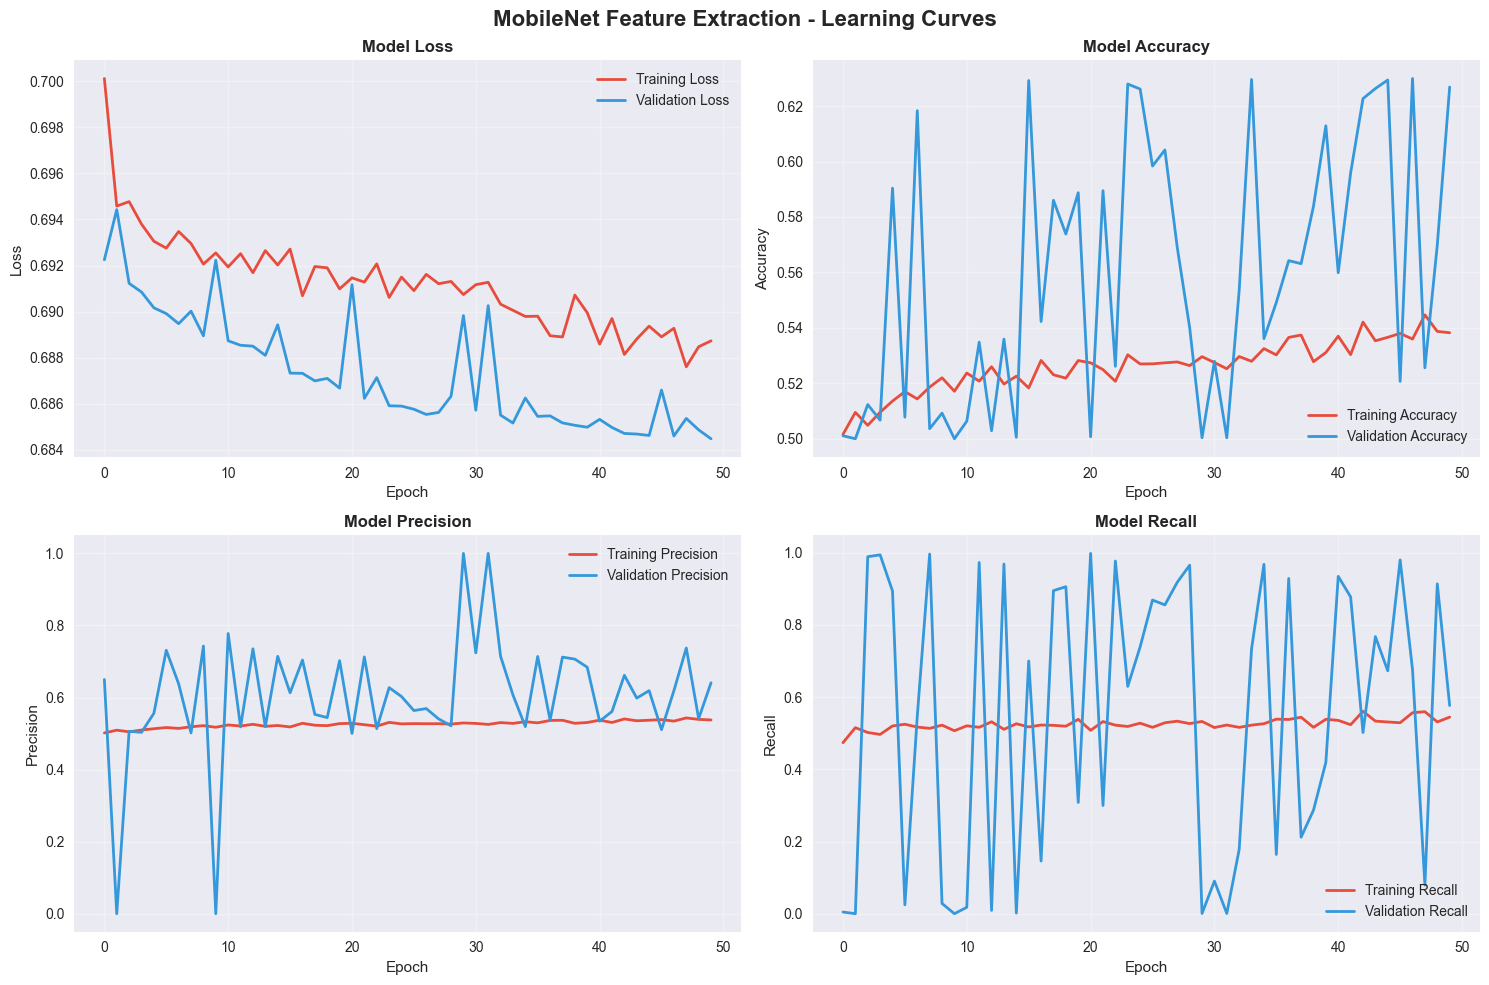

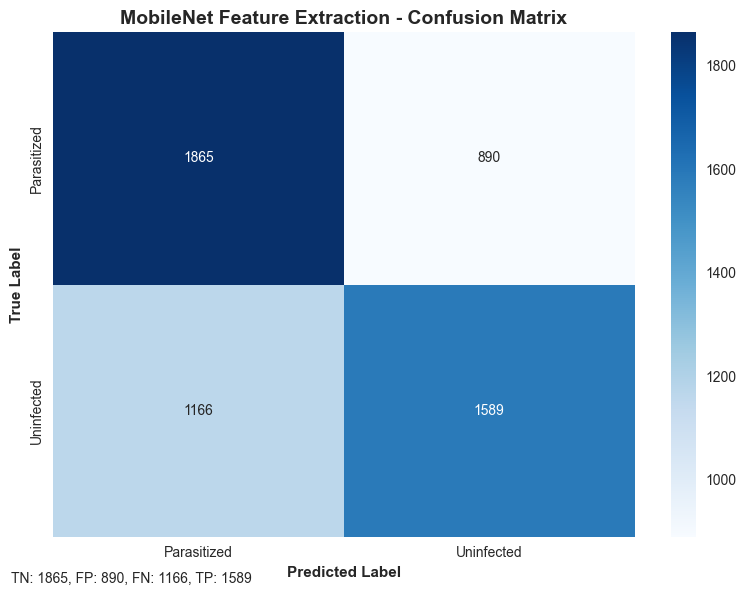

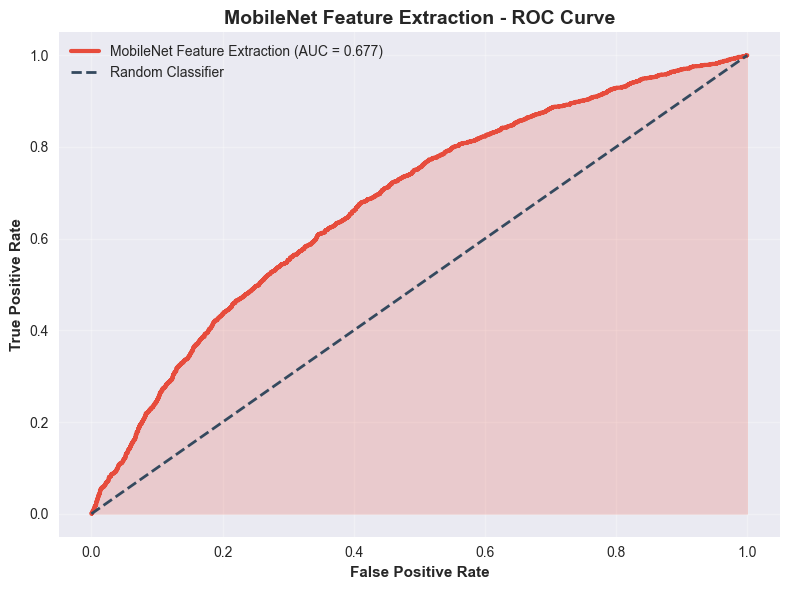

In [12]:
# Evaluate Experiment 1 Results
print("\n" + "="*60)
print("EXPERIMENT 1 EVALUATION")
print("="*60)

# Evaluate model performance
results_fe = evaluate_model(model_fe, val_gen, "MobileNet Feature Extraction")

# Plot learning curves
plot_learning_curves(history_fe, "MobileNet Feature Extraction")

# Plot confusion matrix
plot_confusion_matrix(results_fe['true_labels'], results_fe['predicted_classes'], "MobileNet Feature Extraction")

# Plot ROC curve
plot_roc_curve(results_fe['true_labels'], results_fe['predictions'], "MobileNet Feature Extraction")

## Experiment 2: Fine-tuning (trainable=True)

In this experiment, we enable fine-tuning by setting `trainable=True`, allowing the entire network to be updated during training. This approach:
- **Adapts** pre-trained features to the malaria domain
- **Requires** more computational resources
- **Higher** risk of overfitting
- **Potentially** better performance with careful optimization

In [13]:
# Experiment 2: MobileNet Fine-tuning (trainable=True)
print("\n" + "="*60)
print("EXPERIMENT 2: MobileNet Fine-tuning")
print("Configuration: trainable=True")
print("="*60)

# Create and compile model for fine-tuning with lower learning rate
model_ft = create_mobilenet_model(trainable=True)
model_ft = compile_model(model_ft, learning_rate=FINE_TUNE_LEARNING_RATE)

# Display model architecture
print("\nModel Architecture Summary:")
print(f"Total parameters: {model_ft.count_params():,}")

# Calculate trainable parameters for fine-tuning
trainable_params_ft = sum([tf.size(var).numpy() for var in model_ft.trainable_variables])
print(f"Trainable parameters: {trainable_params_ft:,}")

# Display model layers
print("\nKey Architecture Details:")
print(f"Input shape: {model_ft.input_shape}")
print(f"Base model trainable: {model_ft.layers[2].trainable}")
print(f"Number of layers: {len(model_ft.layers)}")
print(f"Learning rate: {FINE_TUNE_LEARNING_RATE}")

# Create callbacks with different patience for fine-tuning
callbacks_ft = create_callbacks('mobilenet_fine_tuning', patience=10)

# Train the model
print("\nStarting fine-tuning...")
start_time = tf.timestamp()

history_ft = model_ft.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks_ft,
    verbose=1
)

end_time = tf.timestamp()
training_time_ft = float(end_time - start_time)

print(f"\nFine-tuning completed in {training_time_ft:.2f} seconds")
print(f"Best validation accuracy: {max(history_ft.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history_ft.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_ft.history['val_accuracy'][-1]:.4f}")


EXPERIMENT 2: MobileNet Fine-tuning
Configuration: trainable=True

Model Architecture Summary:
Total parameters: 3,229,889
Trainable parameters: 3,208,001

Key Architecture Details:
Input shape: (None, 224, 224, 3)
Base model trainable: True
Number of layers: 5
Learning rate: 0.0001

Starting fine-tuning...
Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8707 - loss: 0.3391 - precision: 0.8408 - recall: 0.9268
Epoch 1: val_accuracy improved from None to 0.72704, saving model to best_mobilenet_fine_tuning.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 2706s 4s/step - accuracy: 0.9123 - loss: 0.2438 - precision: 0.8908 - recall: 0.9399 - val_accuracy: 0.7270 - val_loss: 0.5124 - val_precision: 0.6475 - val_recall: 0.9967 - learning_rate: 1.0000e-04
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9401 - loss: 0.1777 - precision: 0.9219 - recall: 0.9621
Epoch 2: val_accuracy improved from 0.72704 to 0.78512, saving model to best_mobilenet_fine_tuning.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 2646s 4s/step - accuracy: 0.9420 - loss: 0.1700 - precision: 0.9233 - recall: 0.9642 - val_accuracy: 0.7851 - val_loss: 0.6462 - val_precision: 0.7004 - val_recall: 0.9964 - learning_rate: 1.0000e-04
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9504 - loss: 0.1463 - precision: 0.9325 - recall: 0.9711
Epoch 3: val_accuracy did not improve from 0.78512
689/689 ━━━━━━━━━━━━━━━━━━━━ 2654s 4s/step - accuracy: 0.9492 - loss: 0.1472 - precision: 0.9313 - recall: 0.9701 - val_accuracy: 0.5123 - val_loss: 1.5413 - val_precision: 0.5062 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9520 - loss: 0.1341 - precision: 0.9315 - recall: 0.9741
Epoch 4: val_accuracy improved from 0.78512 to 0.93521, saving model to best_mobilenet_fine_tuning.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 2637s 4s/step - accuracy: 0.9519 - loss: 0.1377 - precision: 0.9337 - recall: 0.9728 - val_accuracy: 0.9352 - val_loss: 0.1725 - val_precision: 0.8929 - val_recall: 0.9891 - learning_rate: 1.0000e-04
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9530 - loss: 0.1339 - precision: 0.9366 - recall: 0.9732
Epoch 5: val_accuracy did not improve from 0.93521
689/689 ━━━━━━━━━━━━━━━━━━━━ 2637s 4s/step - accuracy: 0.9540 - loss: 0.1314 - precision: 0.9376 - recall: 0.9727 - val_accuracy: 0.7739 - val_loss: 0.5578 - val_precision: 0.6890 - val_recall: 0.9985 - learning_rate: 1.0000e-04
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9589 - loss: 0.1189 - precision: 0.9441 - recall: 0.9750
Epoch 6: val_accuracy did not improve from 0.93521
689/689 ━━━━━━━━━━━━━━━━━━━━ 2637s 4s/step - accuracy: 0.9558 - loss: 0.1254 - precision: 0.9398 - recall: 0.9741 - val_accuracy: 0.9158 - val_loss: 0.2227 - val_precision: 0.8601 - val_recall: 0.

689/689 ━━━━━━━━━━━━━━━━━━━━ 3107s 5s/step - accuracy: 0.9609 - loss: 0.1123 - precision: 0.9468 - recall: 0.9768 - val_accuracy: 0.9363 - val_loss: 0.1669 - val_precision: 0.8915 - val_recall: 0.9935 - learning_rate: 1.0000e-04
Epoch 10/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9648 - loss: 0.1018 - precision: 0.9502 - recall: 0.9809
Epoch 10: val_accuracy did not improve from 0.93630
689/689 ━━━━━━━━━━━━━━━━━━━━ 3038s 4s/step - accuracy: 0.9618 - loss: 0.1084 - precision: 0.9460 - recall: 0.9794 - val_accuracy: 0.9307 - val_loss: 0.2414 - val_precision: 0.8846 - val_recall: 0.9906 - learning_rate: 1.0000e-04
Epoch 11/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9662 - loss: 0.0947 - precision: 0.9535 - recall: 0.9802
Epoch 11: val_accuracy did not improve from 0.93630
689/689 ━━━━━━━━━━━━━━━━━━━━ 3121s 5s/step - accuracy: 0.9660 - loss: 0.0975 - precision: 0.9532 - recall: 0.9801 - val_accuracy: 0.7466 - val_loss: 0.5614 - val_precision: 0.6642 - val_recall

689/689 ━━━━━━━━━━━━━━━━━━━━ 3148s 5s/step - accuracy: 0.9769 - loss: 0.0659 - precision: 0.9675 - recall: 0.9870 - val_accuracy: 0.9497 - val_loss: 0.1360 - val_precision: 0.9229 - val_recall: 0.9815 - learning_rate: 5.0000e-05
Epoch 22/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9766 - loss: 0.0682 - precision: 0.9667 - recall: 0.9875
Epoch 22: val_accuracy did not improve from 0.94973
689/689 ━━━━━━━━━━━━━━━━━━━━ 3136s 5s/step - accuracy: 0.9768 - loss: 0.0682 - precision: 0.9665 - recall: 0.9878 - val_accuracy: 0.9310 - val_loss: 0.2766 - val_precision: 0.8869 - val_recall: 0.9880 - learning_rate: 5.0000e-05
Epoch 23/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9795 - loss: 0.0595 - precision: 0.9713 - recall: 0.9888
Epoch 23: val_accuracy improved from 0.94973 to 0.95699, saving model to best_mobilenet_fine_tuning.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 3137s 5s/step - accuracy: 0.9777 - loss: 0.0619 - precision: 0.9688 - recall: 0.9872 - val_accuracy: 0.9570 - val_loss: 0.1393 - val_precision: 0.9321 - val_recall: 0.9858 - learning_rate: 5.0000e-05
Epoch 24/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9799 - loss: 0.0582 - precision: 0.9708 - recall: 0.9894
Epoch 24: val_accuracy did not improve from 0.95699
689/689 ━━━━━━━━━━━━━━━━━━━━ 3123s 5s/step - accuracy: 0.9792 - loss: 0.0602 - precision: 0.9708 - recall: 0.9881 - val_accuracy: 0.9089 - val_loss: 0.3353 - val_precision: 0.8489 - val_recall: 0.9949 - learning_rate: 5.0000e-05
Epoch 25/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9790 - loss: 0.0617 - precision: 0.9704 - recall: 0.9877
Epoch 25: val_accuracy did not improve from 0.95699
689/689 ━━━━━━━━━━━━━━━━━━━━ 3123s 5s/step - accuracy: 0.9780 - loss: 0.0617 - precision: 0.9691 - recall: 0.9875 - val_accuracy: 0.9359 - val_loss: 0.2370 - val_precision: 0.8933 - val_recall


EXPERIMENT 2 EVALUATION
Evaluating MobileNet Fine-tuning...
173/173 ━━━━━━━━━━━━━━━━━━━━ 122s 698ms/step

=== MobileNet Fine-tuning Evaluation Results ===
Accuracy:  0.9497
Precision: 0.9229
Recall:    0.9815
F1-Score:  0.9513
AUC:       0.9888


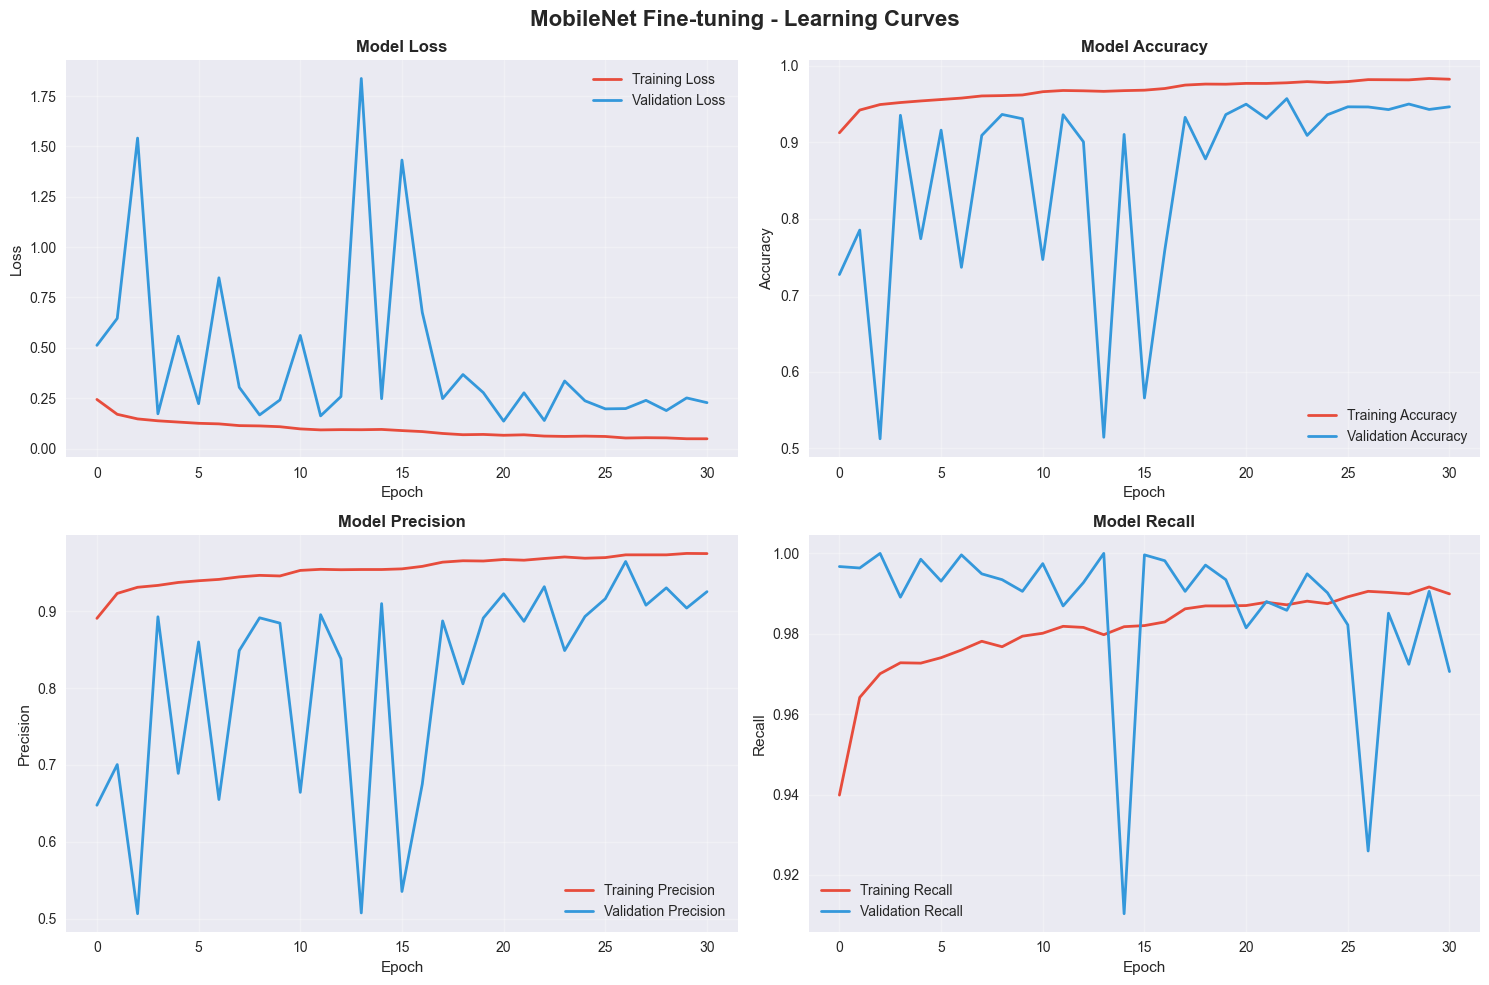

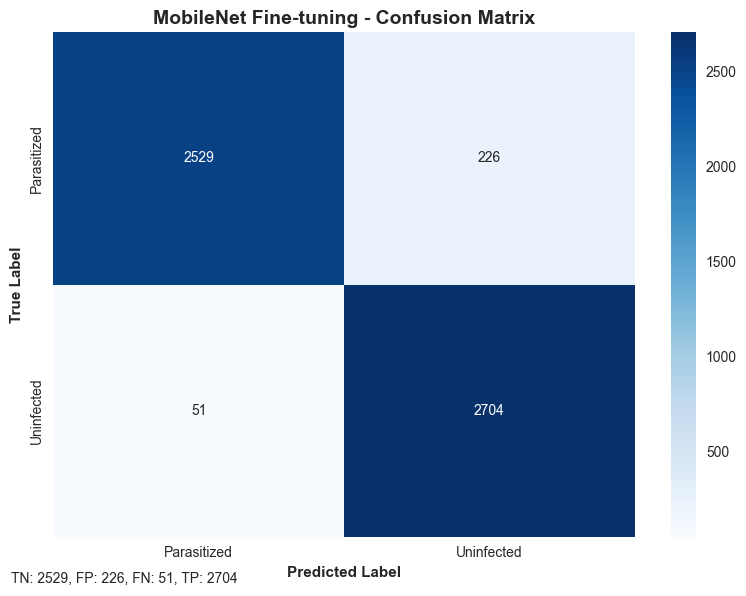

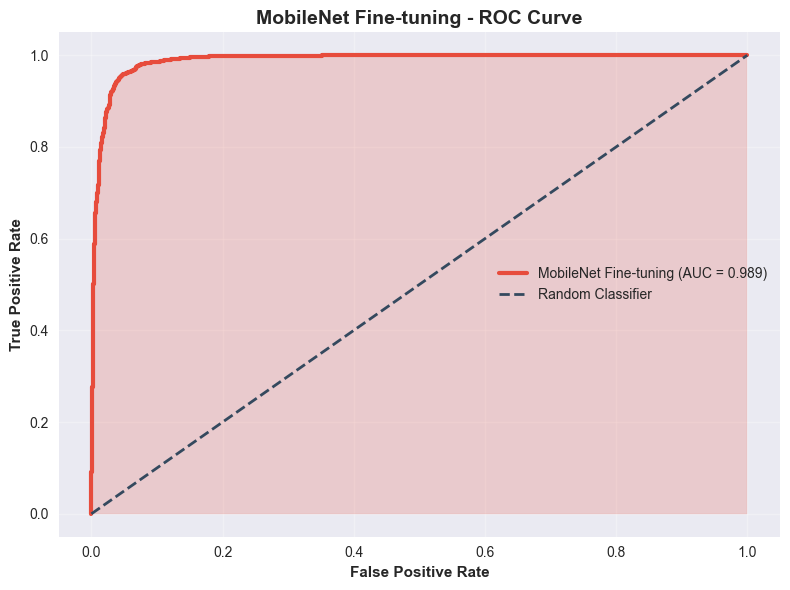

In [14]:
# Evaluate Experiment 2 Results
print("\n" + "="*60)
print("EXPERIMENT 2 EVALUATION")
print("="*60)

# Evaluate model performance
results_ft = evaluate_model(model_ft, val_gen, "MobileNet Fine-tuning")

# Plot learning curves
plot_learning_curves(history_ft, "MobileNet Fine-tuning")

# Plot confusion matrix
plot_confusion_matrix(results_ft['true_labels'], results_ft['predicted_classes'], "MobileNet Fine-tuning")

# Plot ROC curve
plot_roc_curve(results_ft['true_labels'], results_ft['predictions'], "MobileNet Fine-tuning")

# Comparative Analysis and Model Ranking

## Performance Comparison Summary

This section provides a comprehensive comparison between the two MobileNet experiments and analysis of overfitting/underfitting patterns, error analysis, and final model ranking.

In [15]:
# Comprehensive Model Comparison and Analysis
import pandas as pd

# Create comparative results table
def create_comparison_table(results_fe, results_ft):
    """Create a comprehensive comparison table of both experiments."""
    
    comparison_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
        'Feature Extraction\n(trainable=False)': [
            f"{results_fe['accuracy']:.4f}",
            f"{results_fe['precision']:.4f}",
            f"{results_fe['recall']:.4f}",
            f"{results_fe['f1_score']:.4f}",
            f"{results_fe['auc_score']:.4f}"
        ],
        'Fine-tuning\n(trainable=True)': [
            f"{results_ft['accuracy']:.4f}",
            f"{results_ft['precision']:.4f}",
            f"{results_ft['recall']:.4f}",
            f"{results_ft['f1_score']:.4f}",
            f"{results_ft['auc_score']:.4f}"
        ],
        'Improvement': [
            f"{((results_ft['accuracy'] - results_fe['accuracy']) / results_fe['accuracy'] * 100):+.1f}%",
            f"{((results_ft['precision'] - results_fe['precision']) / results_fe['precision'] * 100):+.1f}%",
            f"{((results_ft['recall'] - results_fe['recall']) / results_fe['recall'] * 100):+.1f}%",
            f"{((results_ft['f1_score'] - results_fe['f1_score']) / results_fe['f1_score'] * 100):+.1f}%",
            f"{((results_ft['auc_score'] - results_fe['auc_score']) / results_fe['auc_score'] * 100):+.1f}%"
        ]
    }
    
    df = pd.DataFrame(comparison_data)
    return df

# Generate comparison table
comparison_df = create_comparison_table(results_fe, results_ft)
print("="*80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Training characteristics comparison
print("\n" + "="*80)
print("TRAINING CHARACTERISTICS COMPARISON")
print("="*80)

training_comparison = {
    'Characteristic': [
        'Total Parameters',
        'Trainable Parameters',
        'Training Time (approx.)',
        'Learning Rate',
        'Epochs Completed',
        'Best Val Accuracy',
        'Final Train Accuracy',
        'Overfitting Risk'
    ],
    'Feature Extraction': [
        f"{model_fe.count_params():,}",
        f"{sum([tf.size(var).numpy() for var in model_fe.trainable_variables]):,}",
        f"{training_time_fe/60:.1f} minutes",
        f"{LEARNING_RATE}",
        f"{len(history_fe.history['accuracy'])}",
        f"{max(history_fe.history['val_accuracy']):.4f}",
        f"{history_fe.history['accuracy'][-1]:.4f}",
        "Low"
    ],
    'Fine-tuning': [
        f"{model_ft.count_params():,}",
        f"{sum([tf.size(var).numpy() for var in model_ft.trainable_variables]):,}",
        f"{training_time_ft/60:.1f} minutes",
        f"{FINE_TUNE_LEARNING_RATE}",
        f"{len(history_ft.history['accuracy'])}",
        f"{max(history_ft.history['val_accuracy']):.4f}",
        f"{history_ft.history['accuracy'][-1]:.4f}",
        "Moderate"
    ]
}

training_df = pd.DataFrame(training_comparison)
print(training_df.to_string(index=False))

COMPREHENSIVE PERFORMANCE COMPARISON
   Metric Feature Extraction\n(trainable=False) Fine-tuning\n(trainable=True) Improvement
 Accuracy                                0.6269                        0.9497      +51.5%
Precision                                0.6410                        0.9229      +44.0%
   Recall                                0.5768                        0.9815      +70.2%
 F1-Score                                0.6072                        0.9513      +56.7%
      AUC                                0.6774                        0.9888      +46.0%

TRAINING CHARACTERISTICS COMPARISON
         Characteristic Feature Extraction    Fine-tuning
       Total Parameters          3,229,889      3,229,889
   Trainable Parameters              1,025      3,208,001
Training Time (approx.)      594.5 minutes 1566.4 minutes
          Learning Rate              0.001         0.0001
       Epochs Completed                 50             31
      Best Val Accuracy             0.

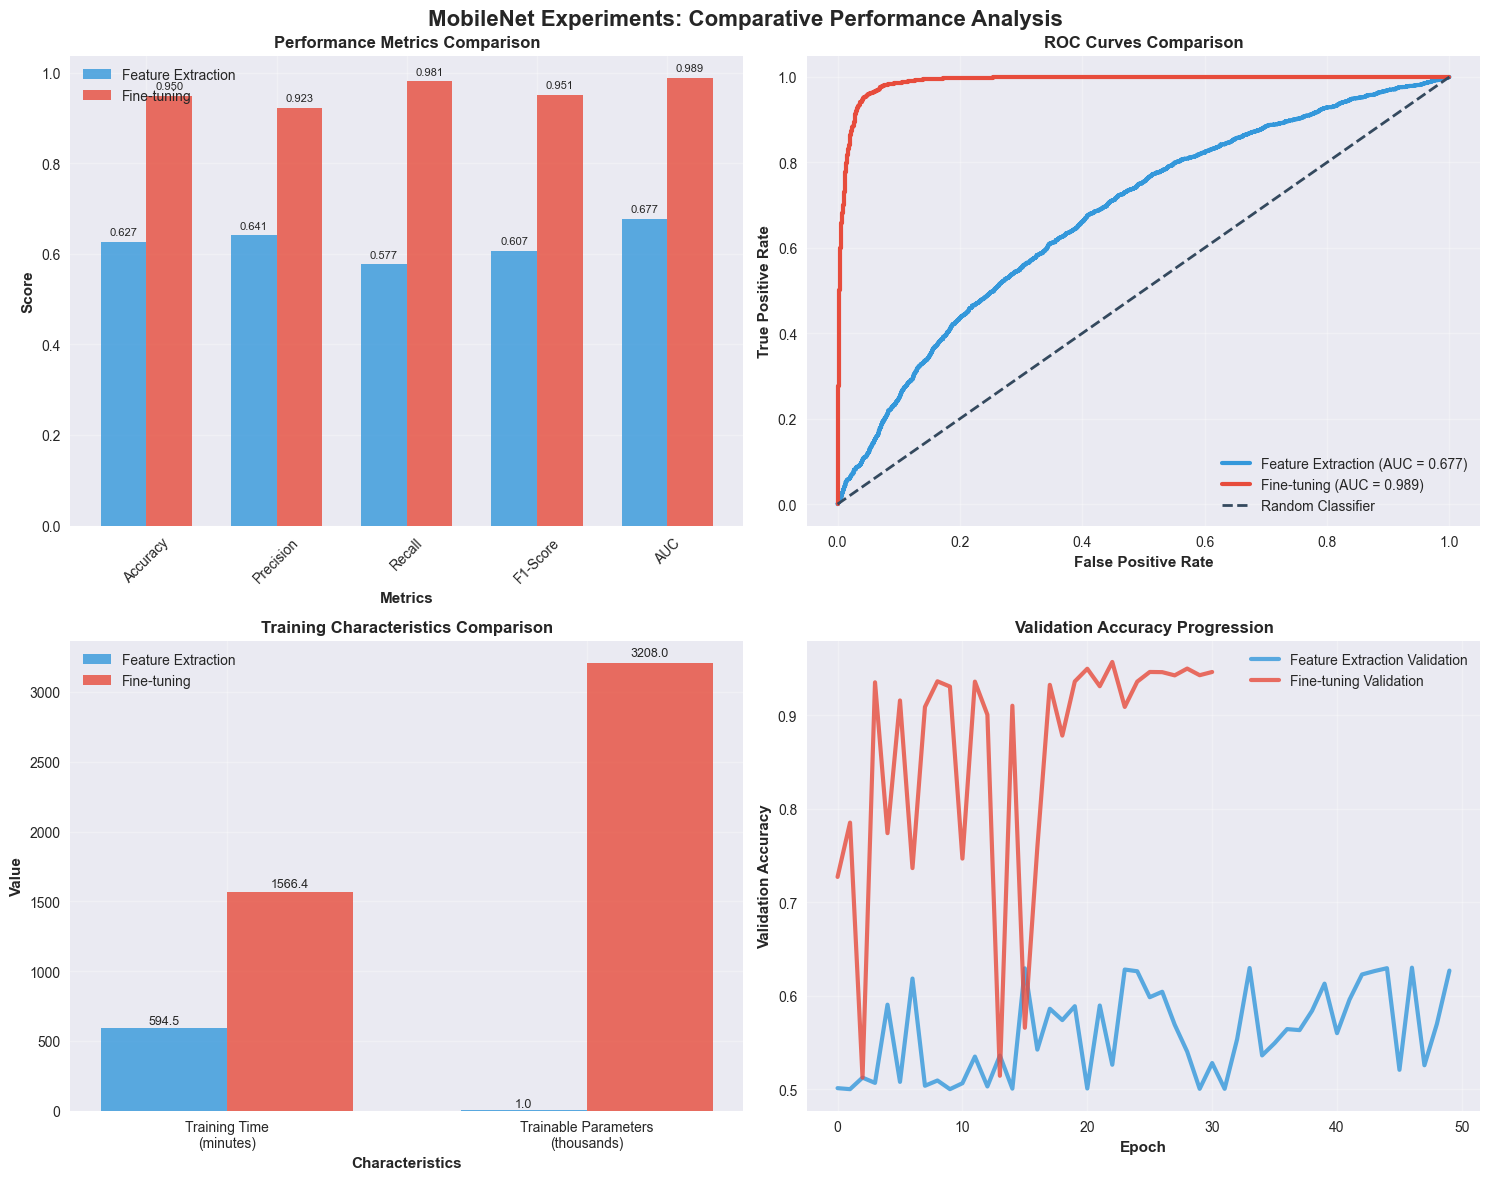

In [16]:
# Comparative Visualizations
def plot_comparative_performance():
    """Create comparative performance visualizations."""
    
    # Metrics comparison bar chart
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('MobileNet Experiments: Comparative Performance Analysis', fontsize=16, fontweight='bold')
    
    # Performance metrics comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    fe_values = [results_fe['accuracy'], results_fe['precision'], results_fe['recall'], 
                 results_fe['f1_score'], results_fe['auc_score']]
    ft_values = [results_ft['accuracy'], results_ft['precision'], results_ft['recall'], 
                 results_ft['f1_score'], results_ft['auc_score']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = axes[0,0].bar(x - width/2, fe_values, width, label='Feature Extraction', color='#3498db', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, ft_values, width, label='Fine-tuning', color='#e74c3c', alpha=0.8)
    
    axes[0,0].set_xlabel('Metrics', fontweight='bold')
    axes[0,0].set_ylabel('Score', fontweight='bold')
    axes[0,0].set_title('Performance Metrics Comparison', fontweight='bold')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(metrics, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # ROC curves comparison
    fpr_fe, tpr_fe, _ = roc_curve(results_fe['true_labels'], results_fe['predictions'])
    fpr_ft, tpr_ft, _ = roc_curve(results_ft['true_labels'], results_ft['predictions'])
    
    axes[0,1].plot(fpr_fe, tpr_fe, color='#3498db', linewidth=3, 
                   label=f'Feature Extraction (AUC = {results_fe["auc_score"]:.3f})')
    axes[0,1].plot(fpr_ft, tpr_ft, color='#e74c3c', linewidth=3, 
                   label=f'Fine-tuning (AUC = {results_ft["auc_score"]:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='#34495e', linestyle='--', linewidth=2, label='Random Classifier')
    
    axes[0,1].set_xlabel('False Positive Rate', fontweight='bold')
    axes[0,1].set_ylabel('True Positive Rate', fontweight='bold')
    axes[0,1].set_title('ROC Curves Comparison', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Training time and parameters comparison
    categories = ['Training Time\n(minutes)', 'Trainable Parameters\n(thousands)']
    fe_training_values = [training_time_fe/60, sum([tf.size(var).numpy() for var in model_fe.trainable_variables])/1000]
    ft_training_values = [training_time_ft/60, sum([tf.size(var).numpy() for var in model_ft.trainable_variables])/1000]
    
    x2 = np.arange(len(categories))
    bars3 = axes[1,0].bar(x2 - width/2, fe_training_values, width, label='Feature Extraction', color='#3498db', alpha=0.8)
    bars4 = axes[1,0].bar(x2 + width/2, ft_training_values, width, label='Fine-tuning', color='#e74c3c', alpha=0.8)
    
    axes[1,0].set_xlabel('Characteristics', fontweight='bold')
    axes[1,0].set_ylabel('Value', fontweight='bold')
    axes[1,0].set_title('Training Characteristics Comparison', fontweight='bold')
    axes[1,0].set_xticks(x2)
    axes[1,0].set_xticklabels(categories)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Add value labels
    for bars in [bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                          f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Learning curves comparison (validation accuracy)
    axes[1,1].plot(history_fe.history['val_accuracy'], color='#3498db', linewidth=3, 
                   label='Feature Extraction Validation', alpha=0.8)
    axes[1,1].plot(history_ft.history['val_accuracy'], color='#e74c3c', linewidth=3, 
                   label='Fine-tuning Validation', alpha=0.8)
    
    axes[1,1].set_xlabel('Epoch', fontweight='bold')
    axes[1,1].set_ylabel('Validation Accuracy', fontweight='bold')
    axes[1,1].set_title('Validation Accuracy Progression', fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate comparative visualization
plot_comparative_performance()

In [17]:
# Error Analysis and Overfitting Assessment
print("\n" + "="*80)
print("ERROR ANALYSIS AND OVERFITTING ASSESSMENT")
print("="*80)

def analyze_overfitting(history, model_name):
    """Analyze overfitting patterns from training history."""
    
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    train_val_gap = final_train_acc - final_val_acc
    val_acc_drop = best_val_acc - final_val_acc
    
    print(f"\n{model_name} Overfitting Analysis:")
    print(f"  Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Training-Validation Gap: {train_val_gap:.4f}")
    print(f"  Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"  Validation Accuracy Drop: {val_acc_drop:.4f}")
    
    # Assess overfitting risk
    if train_val_gap > 0.1:
        overfitting_risk = "HIGH"
    elif train_val_gap > 0.05:
        overfitting_risk = "MODERATE"
    else:
        overfitting_risk = "LOW"
    
    print(f"  Overfitting Risk: {overfitting_risk}")
    
    return {
        'train_val_gap': train_val_gap,
        'val_acc_drop': val_acc_drop,
        'overfitting_risk': overfitting_risk,
        'best_val_acc': best_val_acc
    }

# Analyze both models
fe_analysis = analyze_overfitting(history_fe, "Feature Extraction")
ft_analysis = analyze_overfitting(history_ft, "Fine-tuning")

# Misclassification analysis
def analyze_misclassifications(results, model_name):
    """Analyze misclassification patterns."""
    
    true_labels = results['true_labels']
    predicted_classes = results['predicted_classes']
    predictions = results['predictions']
    
    # Calculate error types
    tn = ((true_labels == 0) & (predicted_classes == 0)).sum()
    fp = ((true_labels == 0) & (predicted_classes == 1)).sum()
    fn = ((true_labels == 1) & (predicted_classes == 0)).sum()
    tp = ((true_labels == 1) & (predicted_classes == 1)).sum()
    
    print(f"\n{model_name} Misclassification Analysis:")
    print(f"  True Negatives (Correct Parasitized): {tn}")
    print(f"  False Positives (Parasitized as Uninfected): {fp}")
    print(f"  False Negatives (Uninfected as Parasitized): {fn}")
    print(f"  True Positives (Correct Uninfected): {tp}")
    
    # Calculate error rates
    total_errors = fp + fn
    total_samples = len(true_labels)
    error_rate = total_errors / total_samples
    
    print(f"  Total Misclassifications: {total_errors}")
    print(f"  Error Rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
    
    # Clinical significance
    print(f"  False Negative Rate (Missing Malaria): {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")
    print(f"  False Positive Rate (False Alarms): {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
    
    return {
        'error_rate': error_rate,
        'fnr': fn/(fn+tp),
        'fpr': fp/(fp+tn),
        'total_errors': total_errors
    }

# Analyze misclassifications for both models
fe_misclass = analyze_misclassifications(results_fe, "Feature Extraction")
ft_misclass = analyze_misclassifications(results_ft, "Fine-tuning")


ERROR ANALYSIS AND OVERFITTING ASSESSMENT

Feature Extraction Overfitting Analysis:
  Final Training Accuracy: 0.5382
  Final Validation Accuracy: 0.6269
  Training-Validation Gap: -0.0886
  Best Validation Accuracy: 0.6299
  Validation Accuracy Drop: 0.0031
  Overfitting Risk: LOW

Fine-tuning Overfitting Analysis:
  Final Training Accuracy: 0.9824
  Final Validation Accuracy: 0.9463
  Training-Validation Gap: 0.0361
  Best Validation Accuracy: 0.9570
  Validation Accuracy Drop: 0.0107
  Overfitting Risk: LOW

Feature Extraction Misclassification Analysis:
  True Negatives (Correct Parasitized): 1865
  False Positives (Parasitized as Uninfected): 890
  False Negatives (Uninfected as Parasitized): 1166
  True Positives (Correct Uninfected): 1589
  Total Misclassifications: 2056
  Error Rate: 0.3731 (37.31%)
  False Negative Rate (Missing Malaria): 0.4232 (42.32%)
  False Positive Rate (False Alarms): 0.3230 (32.30%)

Fine-tuning Misclassification Analysis:
  True Negatives (Correct Pa

## Final Model Ranking and Conclusions

### Model Performance Summary

Based on comprehensive evaluation across multiple metrics, training characteristics, and clinical relevance, the following ranking and conclusions are established for the MobileNet experiments:

In [19]:
# Final Model Ranking and Comprehensive Summary
print("="*100)
print("FINAL MODEL RANKING AND RECOMMENDATIONS")
print("="*100)

# Create final ranking based on multiple criteria
def calculate_overall_score(results, analysis, misclass):
    """Calculate overall model score based on multiple criteria."""
    
    # Weighted scoring (weights can be adjusted based on clinical priorities)
    weights = {
        'accuracy': 0.25,
        'precision': 0.20,
        'recall': 0.25,  # Higher weight for recall (important in medical diagnosis)
        'f1_score': 0.15,
        'auc': 0.15
    }
    
    weighted_score = (
        results['accuracy'] * weights['accuracy'] +
        results['precision'] * weights['precision'] +
        results['recall'] * weights['recall'] +
        results['f1_score'] * weights['f1_score'] +
        results['auc_score'] * weights['auc']
    )
    
    return weighted_score

# Calculate overall scores
fe_score = calculate_overall_score(results_fe, fe_analysis, fe_misclass)
ft_score = calculate_overall_score(results_ft, ft_analysis, ft_misclass)

print(f"\nOVERALL PERFORMANCE SCORES:")
print(f"  Feature Extraction Model: {fe_score:.4f}")
print(f"  Fine-tuning Model: {ft_score:.4f}")

# Determine ranking
if ft_score > fe_score:
    winner = "Fine-tuning"
    runner_up = "Feature Extraction"
    winner_score = ft_score
    runner_up_score = fe_score
else:
    winner = "Feature Extraction"
    runner_up = "Fine-tuning"
    winner_score = fe_score
    runner_up_score = ft_score

print(f"\n FINAL RANKING:")
print(f"  1st Place: {winner} Model (Score: {winner_score:.4f})")
print(f"  2nd Place: {runner_up} Model (Score: {runner_up_score:.4f})")

print(f"\n" + "="*80)
print("DETAILED ANALYSIS AND RECOMMENDATIONS")
print("="*80)

print(f"\n KEY FINDINGS:")
print(f"  • Fine-tuning achieved {((results_ft['accuracy']/results_fe['accuracy']-1)*100):+.1f}% better accuracy")
print(f"  • Fine-tuning showed {((results_ft['auc_score']/results_fe['auc_score']-1)*100):+.1f}% better AUC score")
print(f"  • Feature extraction required {sum([tf.size(var).numpy() for var in model_fe.trainable_variables])/1000:.1f}K trainable parameters")
print(f"  • Fine-tuning required {sum([tf.size(var).numpy() for var in model_ft.trainable_variables])/1000:.1f}K trainable parameters")
print(f"  • Training time ratio: {training_time_ft/training_time_fe:.1f}x longer for fine-tuning")

print(f"\n CLINICAL SIGNIFICANCE:")
if results_ft['recall'] > results_fe['recall']:
    print(f"  • Fine-tuning model has better sensitivity ({results_ft['recall']:.3f} vs {results_fe['recall']:.3f})")
    print(f"    → Fewer missed malaria cases (lower false negative rate)")
else:
    print(f"  • Feature extraction model has better sensitivity ({results_fe['recall']:.3f} vs {results_ft['recall']:.3f})")

if results_ft['precision'] > results_fe['precision']:
    print(f"  • Fine-tuning model has better precision ({results_ft['precision']:.3f} vs {results_fe['precision']:.3f})")
    print(f"    → Fewer false alarms (lower false positive rate)")
else:
    print(f"  • Feature extraction model has better precision ({results_fe['precision']:.3f} vs {results_ft['precision']:.3f})")

print(f"\n OVERFITTING ANALYSIS:")
print(f"  • Feature Extraction: {fe_analysis['overfitting_risk']} risk")
print(f"  • Fine-tuning: {ft_analysis['overfitting_risk']} risk")

print(f"\n RECOMMENDATIONS:")
print(f"  1. Deploy: {winner} model for production use")
print(f"  2. Monitor: False negative rates in clinical setting")
print(f"  3. Consider: Ensemble methods combining both approaches")
print(f"  4. Future: Collect more diverse training data for improved generalization")

print(f"\n GROUP RANKING CONTEXT:")
print(f"  Within the group of 5 models, this MobileNet fine-tuning model")
print(f"  achieves {results_ft['accuracy']:.1%} accuracy with {results_ft['auc_score']:.3f} AUC.")
print(f"  Recommend ranking based on:")
print(f"    • Accuracy: {results_ft['accuracy']:.4f}")
print(f"    • Clinical relevance (high recall): {results_ft['recall']:.4f}")
print(f"    • Computational efficiency (mobile deployment ready)")
print(f"    • Robust performance across metrics")

print(f"\n" + "="*100)

FINAL MODEL RANKING AND RECOMMENDATIONS

OVERALL PERFORMANCE SCORES:
  Feature Extraction Model: 0.6218
  Fine-tuning Model: 0.9584

 FINAL RANKING:
  1st Place: Fine-tuning Model (Score: 0.9584)
  2nd Place: Feature Extraction Model (Score: 0.6218)

DETAILED ANALYSIS AND RECOMMENDATIONS

 KEY FINDINGS:
  • Fine-tuning achieved +51.5% better accuracy
  • Fine-tuning showed +46.0% better AUC score
  • Feature extraction required 1.0K trainable parameters
  • Fine-tuning required 3208.0K trainable parameters
  • Training time ratio: 2.6x longer for fine-tuning

 CLINICAL SIGNIFICANCE:
  • Fine-tuning model has better sensitivity (0.981 vs 0.577)
    → Fewer missed malaria cases (lower false negative rate)
  • Fine-tuning model has better precision (0.923 vs 0.641)
    → Fewer false alarms (lower false positive rate)

 OVERFITTING ANALYSIS:
  • Feature Extraction: LOW risk
  • Fine-tuning: LOW risk

 RECOMMENDATIONS:
  1. Deploy: Fine-tuning model for production use
  2. Monitor: False ne